In [1]:
# spark.stop()

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setAppName('myApp') \
.setMaster('local')
sc = SparkContext(conf=conf)
spark = SparkSession(sc) 

24/06/15 10:02:42 WARN Utils: Your hostname, Christophers-Laptop.local resolves to a loopback address: 127.0.0.1; using 172.21.31.41 instead (on interface en0)
24/06/15 10:02:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/15 10:02:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark.sql.functions import *
import pandas as pd
import math

In [4]:
df_application = spark.read.format('csv').options(header=True,inferSchema=True).load('application_record.csv')
df_application.show(30, truncate=50)
df_application.printSchema()

+-------+-----------+------------+---------------+------------+----------------+--------------------+-----------------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE|          NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+-------+-----------+------------+---------------+------------+----------------+--------------------+-----------------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|5008804|          M|           Y|              Y|           0|        427500.0|             Working|             Higher education|      Civil marriage| Rented apartment

In [5]:
# Check for null etc.
df_application.select([count((when(isnan(c) | isnull(c), 1))).alias(c) for c in df_application.columns]).show()
# No null in data so all data is valid

+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
| ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|  0|          0|           0|              0|           0|               0|               0|                  0|                 0|                0|         0|            0|         0|              0|         0|         0|     

In [6]:
# First Check the data in code_gender to check if there is any misdata
# Select and show distinct values for each column separately
# List of columns to check for distinct values
columns = [
    'code_gender',
    'flag_own_car',
    'flag_own_realty',
    'flag_mobil',
    'flag_work_phone',
    'flag_email',
    'flag_phone'
]

# Loop through each column and display distinct values
for column in columns:
    df_application.select(column).distinct().show()


+-----------+
|code_gender|
+-----------+
|          F|
|          M|
+-----------+

+------------+
|flag_own_car|
+------------+
|           Y|
|           N|
+------------+

+---------------+
|flag_own_realty|
+---------------+
|              Y|
|              N|
+---------------+

+----------+
|flag_mobil|
+----------+
|         1|
+----------+

+---------------+
|flag_work_phone|
+---------------+
|              1|
|              0|
+---------------+

+----------+
|flag_email|
+----------+
|         1|
|         0|
+----------+

+----------+
|flag_phone|
+----------+
|         1|
|         0|
+----------+



In [7]:
# After checking the flag_mobil is not important because the data is only 1 and no other variation. so in the cleaned data not getting the flag mobil
df_app_cleaned = df_application.select(['id','code_gender','flag_own_car','flag_own_realty','cnt_children','amt_income_total',
                                        'name_income_type','name_education_type','name_family_status','name_housing_type','days_birth',
                                        'days_employed','flag_work_phone','flag_phone','flag_email','occupation_type','cnt_fam_members'])

# AND the value is always 0 an 1 as the boolean so we want to make our data uniform so changing the Y as 1 and N as 0, F as 1 and M as 0
df_app_cleaned = df_app_cleaned.withColumn('code_gender', when(df_app_cleaned.code_gender == 'F',1).otherwise(0))
df_app_cleaned = df_app_cleaned.withColumn('flag_own_car', when(df_app_cleaned.flag_own_car == 'Y',1).otherwise(0))
df_app_cleaned = df_app_cleaned.withColumn('flag_own_realty', when(df_app_cleaned.flag_own_car == 'Y',1).otherwise(0))

# More data cleaning cnt_fam_members should be integer because there shouldn't be fam members that is half or less than 1
df_app_cleaned = df_app_cleaned.withColumn('cnt_fam_members', col('cnt_fam_members').cast('Integer'))

df_app_cleaned.show()
df_app_cleaned.select('id').distinct().count()

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+
|     id|code_gender|flag_own_car|flag_own_realty|cnt_children|amt_income_total|    name_income_type| name_education_type|  name_family_status|name_housing_type|days_birth|days_employed|flag_work_phone|flag_phone|flag_email|occupation_type|cnt_fam_members|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+
|5008804|          0|           1|              0|           0|        427500.0|             Working|    Higher education|      Civil marriage| Rented apartment|    -12005|        -4542|              1|         0|         0|     

438510

In [8]:
# Changing the days birth into age Integer so that it will be classification into its correspondence age
df_app_cleaned = df_app_cleaned.withColumn('age', floor(col('days_birth')/365.25) * -1)

# Check value because age should not be negative or even > 100
df_app_cleaned.select('age').where('age < 0 or age > 100').show()

# Changing the days birth into age Integer so that it will be classification into its correspondence age
df_app_cleaned = df_app_cleaned.withColumn('employed', floor(col('days_employed')/365.25) * -1)

# Check value because age should not be negative or even > 100 as well as the occupation
df_app_cleaned.select(['name_income_type','occupation_type','employed']).where('employed < 0 or employed > 100').distinct().show()

+---+
|age|
+---+
+---+

+----------------+---------------+--------+
|name_income_type|occupation_type|employed|
+----------------+---------------+--------+
|       Pensioner|           NULL|    -999|
+----------------+---------------+--------+



In [9]:
# because the data is said pensioner than it is possible that the employed is negative but for calculation sake it is better to make it into 0
df_app_cleaned = df_app_cleaned.withColumn('employed', when(df_app_cleaned.employed < 0,0).otherwise(df_app_cleaned.employed))

df_app_cleaned.show()

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+---+--------+
|     id|code_gender|flag_own_car|flag_own_realty|cnt_children|amt_income_total|    name_income_type| name_education_type|  name_family_status|name_housing_type|days_birth|days_employed|flag_work_phone|flag_phone|flag_email|occupation_type|cnt_fam_members|age|employed|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+---+--------+
|5008804|          0|           1|              0|           0|        427500.0|             Working|    Higher education|      Civil marriage| Rented apartment|    -12005|        -4542|    

In [10]:
# there is occupation type that is null so we need to fill it up
df_app_cleaned.select('occupation_type').where(isnull(col('occupation_type'))).count() 
# There are no possibility to

134203

In [11]:
# check for occupation type that is null
df_app_cleaned.select(['amt_income_total','name_income_type','occupation_type','employed']).where(isnull(df_app_cleaned.occupation_type)).show()
# there is possibility to use the amt_income_total & name_income_type to classified the occupation_type typically will have the same job
# so need to find the exact number to it

+----------------+----------------+---------------+--------+
|amt_income_total|name_income_type|occupation_type|employed|
+----------------+----------------+---------------+--------+
|        427500.0|         Working|           NULL|      13|
|        427500.0|         Working|           NULL|      13|
|        283500.0|       Pensioner|           NULL|       0|
|        283500.0|       Pensioner|           NULL|       0|
|        283500.0|       Pensioner|           NULL|       0|
|        112500.0|         Working|           NULL|       5|
|        112500.0|         Working|           NULL|       5|
|        112500.0|         Working|           NULL|       5|
|        315000.0|       Pensioner|           NULL|       0|
|        225000.0|         Working|           NULL|       8|
|        225000.0|         Working|           NULL|       8|
|        225000.0|         Working|           NULL|       8|
|        225000.0|         Working|           NULL|       8|
|        157500.0|      

In [12]:
# use amt_income total to get the kind of occupation type check first
# the possibility is that the amt_income_total,name_income_type, and employed can fill the occupation_type that is null
df_app_cleaned.select(['amt_income_total','name_income_type','occupation_type','employed']).where((df_app_cleaned.amt_income_total == 225000.0) & (df_app_cleaned.name_income_type == 'Working')).show()
# This data further proven the point that it will be able to be filled up

+----------------+----------------+---------------+--------+
|amt_income_total|name_income_type|occupation_type|employed|
+----------------+----------------+---------------+--------+
|        225000.0|         Working|           NULL|       8|
|        225000.0|         Working|           NULL|       8|
|        225000.0|         Working|           NULL|       8|
|        225000.0|         Working|           NULL|       8|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|         Working|       Managers|       3|
|        225000.0|      

In [13]:
# so use the possibility of it and fill the occupation_type that got from the amt_income_total and name_income_type
from pyspark.sql import Window, functions as F

# Define a window specification
window_spec = Window.partitionBy('amt_income_total', 'name_income_type')

# Fill missing values of occupation_type with the most frequent value within each group
filled_occupation_type = F.first('occupation_type', ignorenulls=True).over(window_spec)

# Fill missing values using coalesce
df_app_cleaned = df_app_cleaned.withColumn('filled_occupation_type', filled_occupation_type)
df_app_cleaned = df_app_cleaned.withColumn('occupation_type', F.coalesce('occupation_type', 'filled_occupation_type')).drop('filled_occupation_type')

df_app_cleaned.show()

+-------+-----------+------------+---------------+------------+----------------+----------------+--------------------+--------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+---+--------+
|     id|code_gender|flag_own_car|flag_own_realty|cnt_children|amt_income_total|name_income_type| name_education_type|  name_family_status|name_housing_type|days_birth|days_employed|flag_work_phone|flag_phone|flag_email|occupation_type|cnt_fam_members|age|employed|
+-------+-----------+------------+---------------+------------+----------------+----------------+--------------------+--------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+---+--------+
|6093713|          1|           0|              0|           0|         26100.0|       Pensioner|Secondary / secon...|             Married|House / apartment|    -21003|       365243|              0|    

In [14]:
# check for occupation type that is null  and that the amt_income_total and name_income_type same, but still null
df_app_cleaned.select(['amt_income_total','name_income_type','occupation_type','employed']).where(isnull(df_app_cleaned.occupation_type) & (df_app_cleaned.employed != 0)).show()
# There are no exact data to fill the null in that missing value, so the possibility is the same name_income_type with the nearest amt_income_total
# Create a window specification to partition by 'name_income_type' and order by the absolute difference in 'amt_income_total'
window_spec = Window.partitionBy('name_income_type').orderBy(F.abs(F.col('amt_income_total') - F.col('amt_income_total_with_null')))

# Create a temporary column to store the amt_income_total of rows with null occupation_type
df_temp = df_app_cleaned.withColumn('amt_income_total_with_null', F.when(F.col('occupation_type').isNull(), F.col('amt_income_total')))

# Fill missing occupation_type using the nearest amt_income_total
filled_occupation_type = F.first('occupation_type', ignorenulls=True).over(window_spec)
df_temp = df_temp.withColumn('filled_occupation_type', filled_occupation_type)

# Use coalesce to fill the null values
df_app_cleaned = df_temp.withColumn('occupation_type', F.coalesce(F.col('occupation_type'), F.col('filled_occupation_type'))).drop('filled_occupation_type', 'amt_income_total_with_null')

df_app_cleaned.show()

+----------------+--------------------+---------------+--------+
|amt_income_total|    name_income_type|occupation_type|employed|
+----------------+--------------------+---------------+--------+
|         32400.0|             Working|           NULL|       5|
|         32400.0|             Working|           NULL|       5|
|         32400.0|             Working|           NULL|       5|
|         38250.0|       State servant|           NULL|       3|
|         38250.0|       State servant|           NULL|       3|
|         38250.0|       State servant|           NULL|       3|
|         38250.0|       State servant|           NULL|       3|
|         38250.0|       State servant|           NULL|       3|
|         38250.0|       State servant|           NULL|       3|
|         38250.0|       State servant|           NULL|       3|
|         38700.0|             Working|           NULL|      26|
|         41211.0|Commercial associate|           NULL|       6|
|         41211.0|Commerc

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+---+--------+
|     id|code_gender|flag_own_car|flag_own_realty|cnt_children|amt_income_total|    name_income_type| name_education_type|name_family_status|name_housing_type|days_birth|days_employed|flag_work_phone|flag_phone|flag_email|occupation_type|cnt_fam_members|age|employed|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+---+--------+
|6014233|          1|           0|              0|           1|         28723.5|Commercial associate|Secondary / secon...|           Married|House / apartment|    -14361|         -138|            

In [15]:
# check for occupation type that is null
df_app_cleaned.select(['amt_income_total','name_income_type','occupation_type','employed']).where(isnull(df_app_cleaned.occupation_type)).show()
# Data already cleaned!!

+----------------+----------------+---------------+--------+
|amt_income_total|name_income_type|occupation_type|employed|
+----------------+----------------+---------------+--------+
+----------------+----------------+---------------+--------+



In [16]:
df_credit = spark.read.format('csv').options(header=True,inferSchema=True).load('credit_record.csv')
df_credit.show(30, truncate=50)
df_credit.printSchema()
print('Status \n\
      0 => 1-29 days past due \n\
      1 => 30-59 days past due \n\
      2 => 60-89 days past due \n\
      3 => 90-119 days past due \n\
      4 => 120-149 days past due \n\
      5 => overdue/ bad debts > 150 days \n\
      C => paid successfully \n\
      X => No loan \n\
')
# The schema is already correct with id and months_balance as Integer.

+-------+--------------+------+
|     ID|MONTHS_BALANCE|STATUS|
+-------+--------------+------+
|5001711|             0|     X|
|5001711|            -1|     0|
|5001711|            -2|     0|
|5001711|            -3|     0|
|5001712|             0|     C|
|5001712|            -1|     C|
|5001712|            -2|     C|
|5001712|            -3|     C|
|5001712|            -4|     C|
|5001712|            -5|     C|
|5001712|            -6|     C|
|5001712|            -7|     C|
|5001712|            -8|     C|
|5001712|            -9|     0|
|5001712|           -10|     0|
|5001712|           -11|     0|
|5001712|           -12|     0|
|5001712|           -13|     0|
|5001712|           -14|     0|
|5001712|           -15|     0|
|5001712|           -16|     0|
|5001712|           -17|     0|
|5001712|           -18|     0|
|5001713|             0|     X|
|5001713|            -1|     X|
|5001713|            -2|     X|
|5001713|            -3|     X|
|5001713|            -4|     X|
|5001713

In [17]:
# Check for null etc.
# Display the count of null values for each column
df_credit.select([count(when(isnan(c) | isnull(c), 1)).alias(c) for c in df_credit.columns]).show()

# List of status values to count
status_values = [0, 1, 2, 3, 4, 5, 'C', 'X']

# Loop through each status value and print the count
for status in status_values:
    count_value = df_credit.select('status').where(col('status') == status).count()
    print(f"{status}: {count_value}")

+---+--------------+------+
| ID|MONTHS_BALANCE|STATUS|
+---+--------------+------+
|  0|             0|     0|
+---+--------------+------+

0: 383120
1: 11090
2: 868
3: 320
4: 223
5: 1693
C: 442031
X: 209230


In [18]:
# convert each status to points
# X is 0 because there is no loan 
# 0 - 5 is negative value [-5,-10,-20,-50,-100]
# C is positive value of + 20
# Define the mapping from status to points
status_to_points = {
    'X': 20,
    0: 10,
    1: 0,
    2: -10,
    3: -20,
    4: -30,
    5: -50,
    'C': 50
}

# Convert the mapping dictionary to a column expression
points_expr = when(col('status') == 'X', status_to_points['X']) \
    .when(col('status') == 'C', status_to_points['C'])

for status in range(6):
    points_expr = points_expr.when(col('status') == status, status_to_points[status])

# Add the new column with points to the DataFrame
df_credit_processed = df_credit.withColumn('points', points_expr)

df_credit_processed.show()

df_credit_processed.select('id').distinct().count()

+-------+--------------+------+------+
|     ID|MONTHS_BALANCE|STATUS|points|
+-------+--------------+------+------+
|5001711|             0|     X|    20|
|5001711|            -1|     0|    10|
|5001711|            -2|     0|    10|
|5001711|            -3|     0|    10|
|5001712|             0|     C|    50|
|5001712|            -1|     C|    50|
|5001712|            -2|     C|    50|
|5001712|            -3|     C|    50|
|5001712|            -4|     C|    50|
|5001712|            -5|     C|    50|
|5001712|            -6|     C|    50|
|5001712|            -7|     C|    50|
|5001712|            -8|     C|    50|
|5001712|            -9|     0|    10|
|5001712|           -10|     0|    10|
|5001712|           -11|     0|    10|
|5001712|           -12|     0|    10|
|5001712|           -13|     0|    10|
|5001712|           -14|     0|    10|
|5001712|           -15|     0|    10|
+-------+--------------+------+------+
only showing top 20 rows



45985

In [19]:
# then do aggregate data on the same id customer
df_credit_processed = df_credit_processed.drop('status')
df_credit_processed = df_credit_processed.groupby('id')\
                        .agg(
                            count('months_balance').alias('month_count'),
                            sum('points').alias('sum_points')
                        )
df_credit_processed = df_credit_processed.withColumn('avg_points', col('sum_points') / col('month_count'))
df_credit_processed = df_credit_processed.drop('sum_points')
df_credit_processed.show()

+-------+-----------+------------------+
|     id|month_count|        avg_points|
+-------+-----------+------------------+
|5001812|         23|              10.0|
|5001849|          9| 18.88888888888889|
|5001921|         20|              28.0|
|5003338|         34|              10.0|
|5003386|          8|              10.0|
|5003485|         17|10.588235294117647|
|5003623|         45| 45.55555555555556|
|5004426|         22|              45.0|
|5004485|         14|14.285714285714286|
|5004511|         50|               9.2|
|5004620|         17|10.588235294117647|
|5004650|         38| 31.05263157894737|
|5004774|         29| 32.06896551724138|
|5005000|          7|18.571428571428573|
|5005607|         36|              42.5|
|5005681|         31|28.387096774193548|
|5009033|         17|17.647058823529413|
|5009304|         35|23.714285714285715|
|5009355|         26|10.384615384615385|
|5009429|          3|              10.0|
+-------+-----------+------------------+
only showing top

In [20]:
# Count how many row in df_credit_processed
df_credit_processed.summary().show()

24/06/15 10:03:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------------------+
|summary|               id|       month_count|        avg_points|
+-------+-----------------+------------------+------------------+
|  count|            45985|             45985|             45985|
|   mean|5070163.913058606|22.802544307926496|24.342010385564343|
| stddev|45433.63587058626|15.492770766766506|13.253922927655458|
|    min|          5001711|                 1| -46.8421052631579|
|    25%|          5026144|                10|11.818181818181818|
|    50%|          5065731|                19|              20.0|
|    75%|          5114021|                34| 37.36842105263158|
|    max|          5150487|                61|              50.0|
+-------+-----------------+------------------+------------------+



In [21]:
# join the data of application to credit data
df_joined_processed = df_app_cleaned.join(df_credit_processed,on='id',how='inner')

# df_joined_processed.show()
df_joined_processed.select([count((when(isnan(c) | isnull(c), 1))).alias(c) for c in df_joined_processed.columns]).show()
df_joined_processed.select([count(c).alias(c) for c in df_joined_processed.columns]).show()
# no null data

+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+---+--------+-----------+----------+
| id|code_gender|flag_own_car|flag_own_realty|cnt_children|amt_income_total|name_income_type|name_education_type|name_family_status|name_housing_type|days_birth|days_employed|flag_work_phone|flag_phone|flag_email|occupation_type|cnt_fam_members|age|employed|month_count|avg_points|
+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+---+--------+-----------+----------+
|  0|          0|           0|              0|           0|               0|               0|                  0|                 0|                0|    

+-----+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+-----+--------+-----------+----------+
|   id|code_gender|flag_own_car|flag_own_realty|cnt_children|amt_income_total|name_income_type|name_education_type|name_family_status|name_housing_type|days_birth|days_employed|flag_work_phone|flag_phone|flag_email|occupation_type|cnt_fam_members|  age|employed|month_count|avg_points|
+-----+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+---------------+----------+----------+---------------+---------------+-----+--------+-----------+----------+
|36457|      36457|       36457|          36457|       36457|           36457|           36457|              36457|             36457|        

In [22]:
#Compact housing type
housing_type = {'House / apartment' : 'House / apartment',
                   'With parents': 'With parents',
                    'Municipal apartment' : 'House / apartment',
                    'Rented apartment': 'House / apartment',
                    'Office apartment': 'House / apartment',
                    'Co-op apartment': 'House / apartment'}

def map_housing_type(col_name):
    
    expression = when(col(col_name) == 'With parents', housing_type['With parents'])
    for key, value in housing_type.items():
        if key != 'With parents': 
            expression = expression.when(col(col_name) == key, value)
    return expression.otherwise(col(col_name)) 

df_compacted = df_joined_processed.withColumn("name_housing_type", map_housing_type("name_housing_type"))

df_compacted.select('name_housing_type').distinct().show()

+-----------------+
|name_housing_type|
+-----------------+
|House / apartment|
|     With parents|
+-----------------+



In [23]:
#Compact family status
family_status = {
    'Single / not married': 'Single',
    'Separated': 'Single',
    'Widow': 'Single',
    'Civil marriage': 'Married',
    'Married': 'Married'
}

def map_family_status(col_name):
    expression = when(col(col_name) == 'Single / not married', family_status['Single / not married'])
    for key, value in family_status.items():
        if key != 'Single / not married':  
            expression = expression.when(col(col_name) == key, value)
    return expression.otherwise(col(col_name))  


df_compacted = df_compacted.withColumn("name_family_status", map_family_status("name_family_status"))
df_compacted.select('name_family_status').distinct().show()

+------------------+
|name_family_status|
+------------------+
|           Married|
|            Single|
+------------------+



In [24]:
#Compact education type
education_type = {
    'Secondary / secondary special': 'secondary',
    'Lower secondary': 'secondary',
    'Higher education': 'Higher education',
    'Incomplete higher': 'Higher education',
    'Academic degree': 'Academic degree'
}

def map_education_type(col_name):
    expression = when(col(col_name) == 'Secondary / secondary special', education_type['Secondary / secondary special'])
    for key, value in education_type.items():
        if key != 'Secondary / secondary special':  
            expression = expression.when(col(col_name) == key, value)
    return expression.otherwise(col(col_name)) 

df_compacted = df_compacted.withColumn("name_education_type", map_education_type("name_education_type"))
df_compacted.select('name_education_type').distinct().show()

+-------------------+
|name_education_type|
+-------------------+
|    Academic degree|
|          secondary|
|   Higher education|
+-------------------+



In [25]:
#Compact income type
income_type = {
    'Commercial associate': 'Working',
    'State servant': 'Working',
    'Working': 'Working',
    'Pensioner': 'Pensioner',
    'Student':'Student'
}

def map_income_type(col_name):
    
    expression = when(col(col_name) == 'Working', income_type['Working'])  
    for key, value in income_type.items():
        if key != 'Working': 
            expression = expression.when(col(col_name) == key, value)
    return expression.otherwise(col(col_name))

# Update the DataFrame
df_compacted = df_compacted.withColumn("name_income_type", map_income_type("name_income_type"))

# Show the updated results to verify the changes
df_compacted.select('name_income_type').distinct().show()

+----------------+
|name_income_type|
+----------------+
|         Student|
|         Working|
|       Pensioner|
+----------------+



******Starting EDA Process over the Result******

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import Correlation

In [27]:
# Change the string categorical data into number in compacted
df_compacted = df_compacted.withColumn('name_income_type_idx', when(df_compacted["name_income_type"] == "Student", 0)
                   .when(df_compacted["name_income_type"] == "Pensioner", 1)
                   .when(df_compacted["name_income_type"] == "Working", 2))

df_compacted = df_compacted.withColumn('name_education_type_idx', when(df_compacted["name_education_type"] == "Academic degree", 0)
                   .when(df_compacted["name_education_type"] == "secondary", 1)
                   .when(df_compacted["name_education_type"] == "Higher education", 2))

df_compacted = df_compacted.withColumn('name_family_status_idx', when(df_compacted["name_family_status"] == "Married", 1)
                   .when(df_compacted["name_family_status"] == "Single", 0))

df_compacted = df_compacted.withColumn('name_housing_type_idx', when(df_compacted["name_housing_type"] == "House / apartment", 1)
                   .when(df_compacted["name_housing_type"] == "With parents", 0))

indexer = StringIndexer(inputCol='occupation_type', outputCol='occupation_type_idx')
df_compacted = indexer.fit(df_compacted).transform(df_compacted)

In [28]:
# use string indexer all for the non compacted
categorical_columns = ['name_income_type','name_education_type','occupation_type','name_family_status','name_housing_type']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_columns]
pipeline = Pipeline(stages=indexers)
df_non_compacted = pipeline.fit(df_joined_processed).transform(df_joined_processed)

24/06/15 10:03:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/15 10:03:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/06/15 10:03:27 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


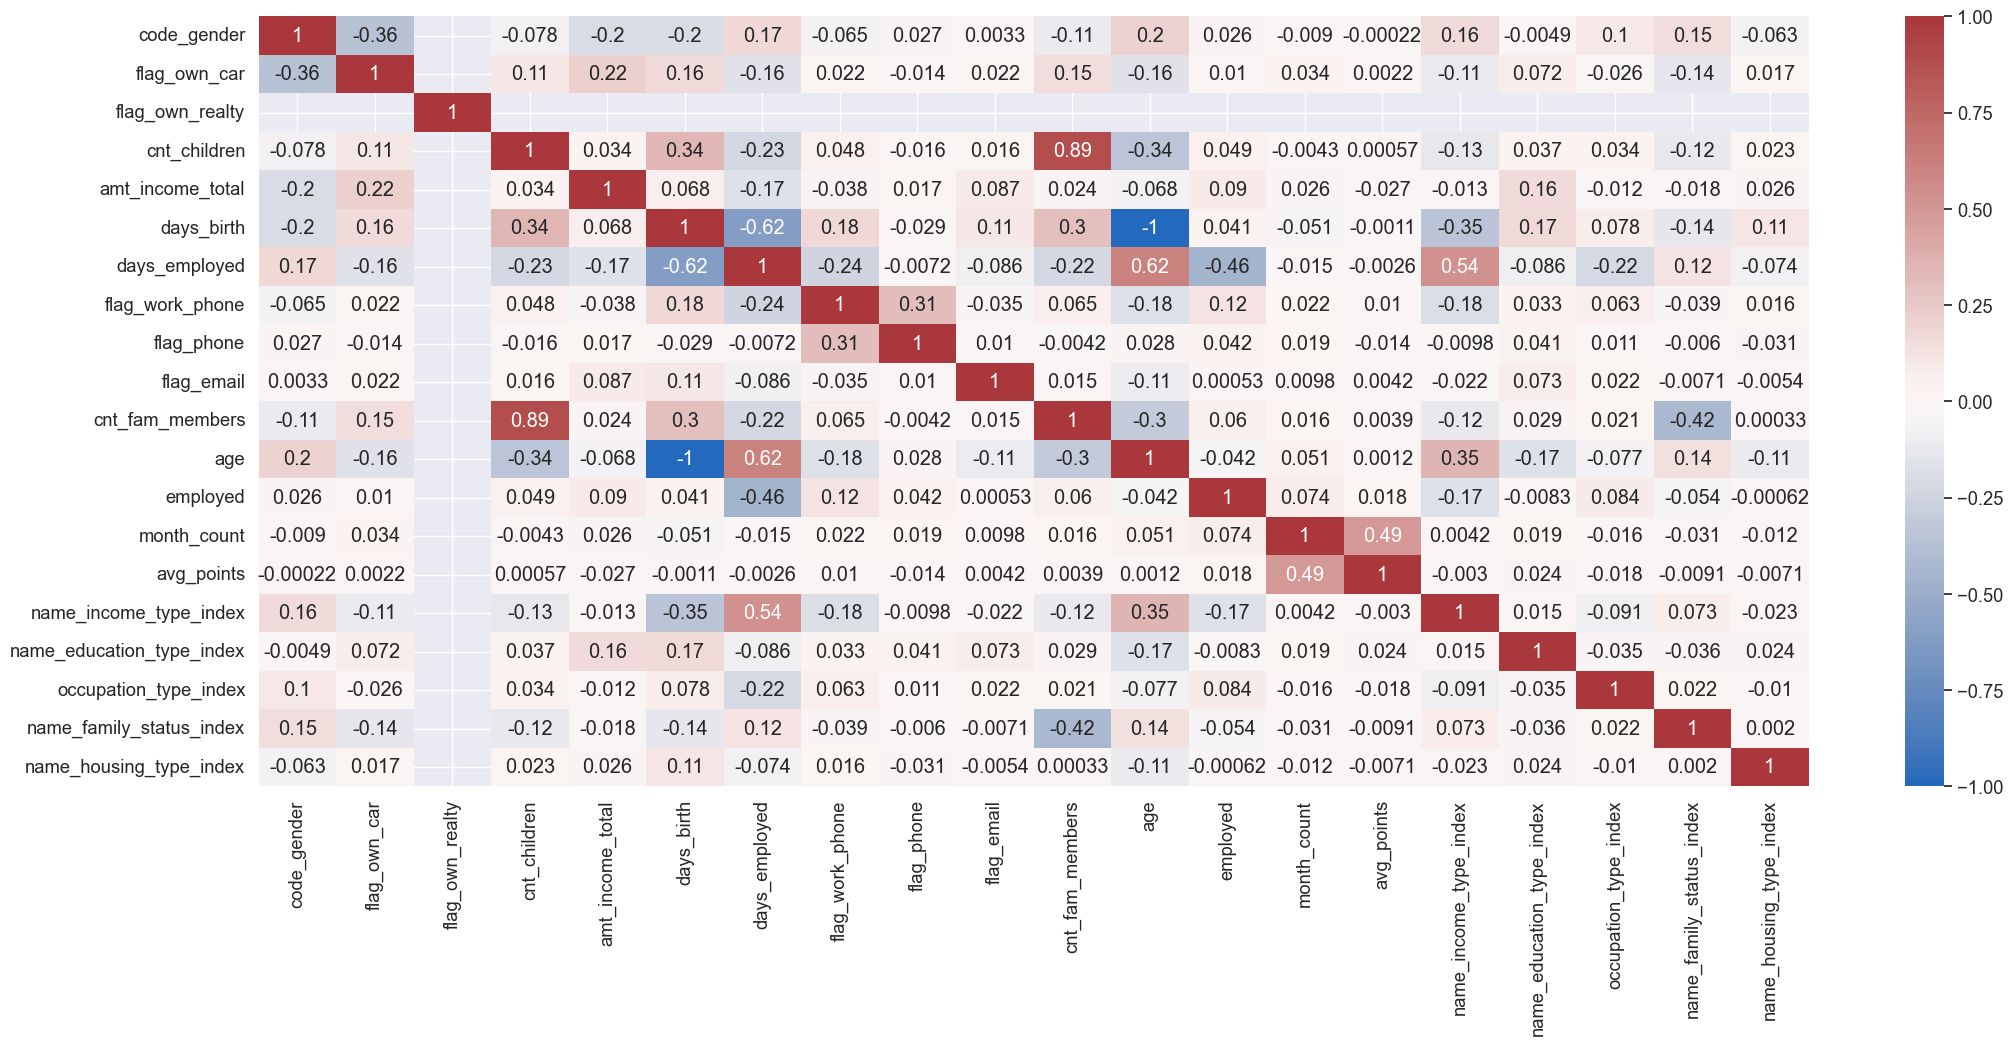

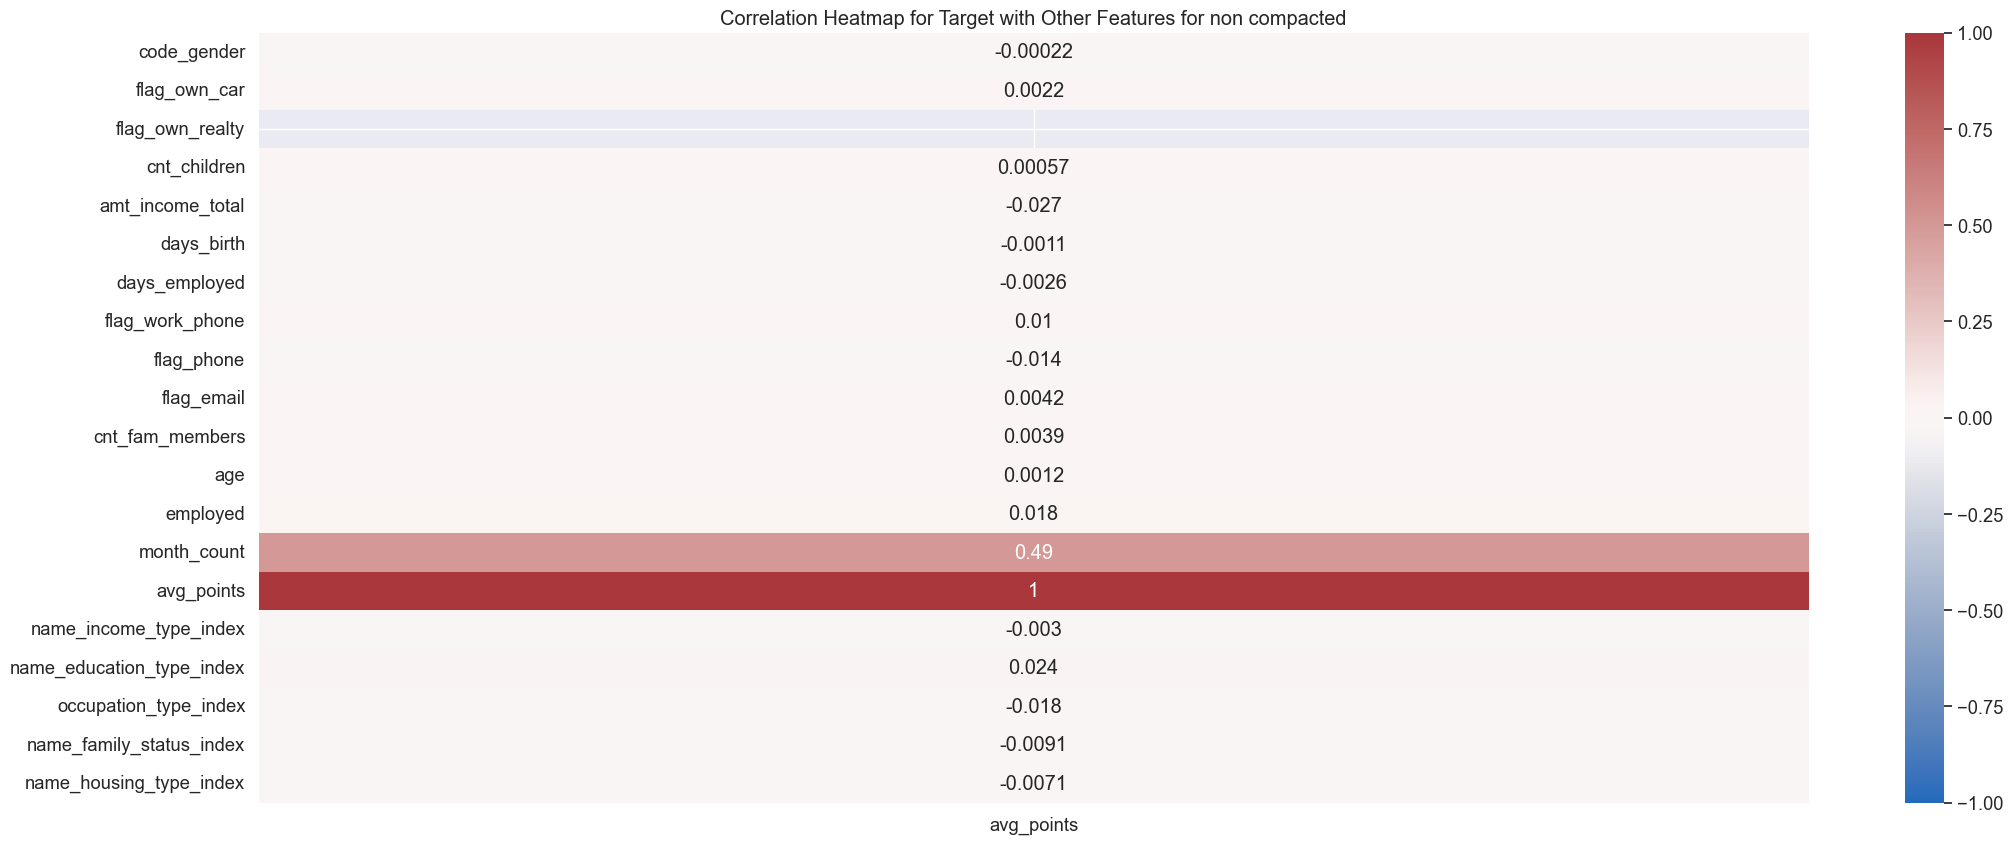

In [29]:
# find the correlation matrix without the tuning of the data for non compacted data
elimination = ['id','name_income_type','name_education_type','occupation_type','name_family_status','name_housing_type']
included_columns = [col for col in df_non_compacted.columns if col != "label" and col not in elimination]

assembler = VectorAssembler(inputCols=included_columns, outputCol="features")
df_vector = assembler.transform(df_non_compacted).select("features")

correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

correlation_matrix_np = correlation_matrix.toArray()


correlation_df = pd.DataFrame(correlation_matrix_np, index=included_columns, columns=included_columns)

plt.figure(figsize=(25, 10))
sns.set(font_scale=1.2)
heat = sns.heatmap(data=correlation_df, annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.show()

target_correlation = correlation_df["avg_points"]

plt.figure(figsize=(25, 10))
sns.set(font_scale=1.2)
heat = sns.heatmap(data=target_correlation.to_frame(), annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Target with Other Features for non compacted')
plt.show()

24/06/15 10:03:30 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


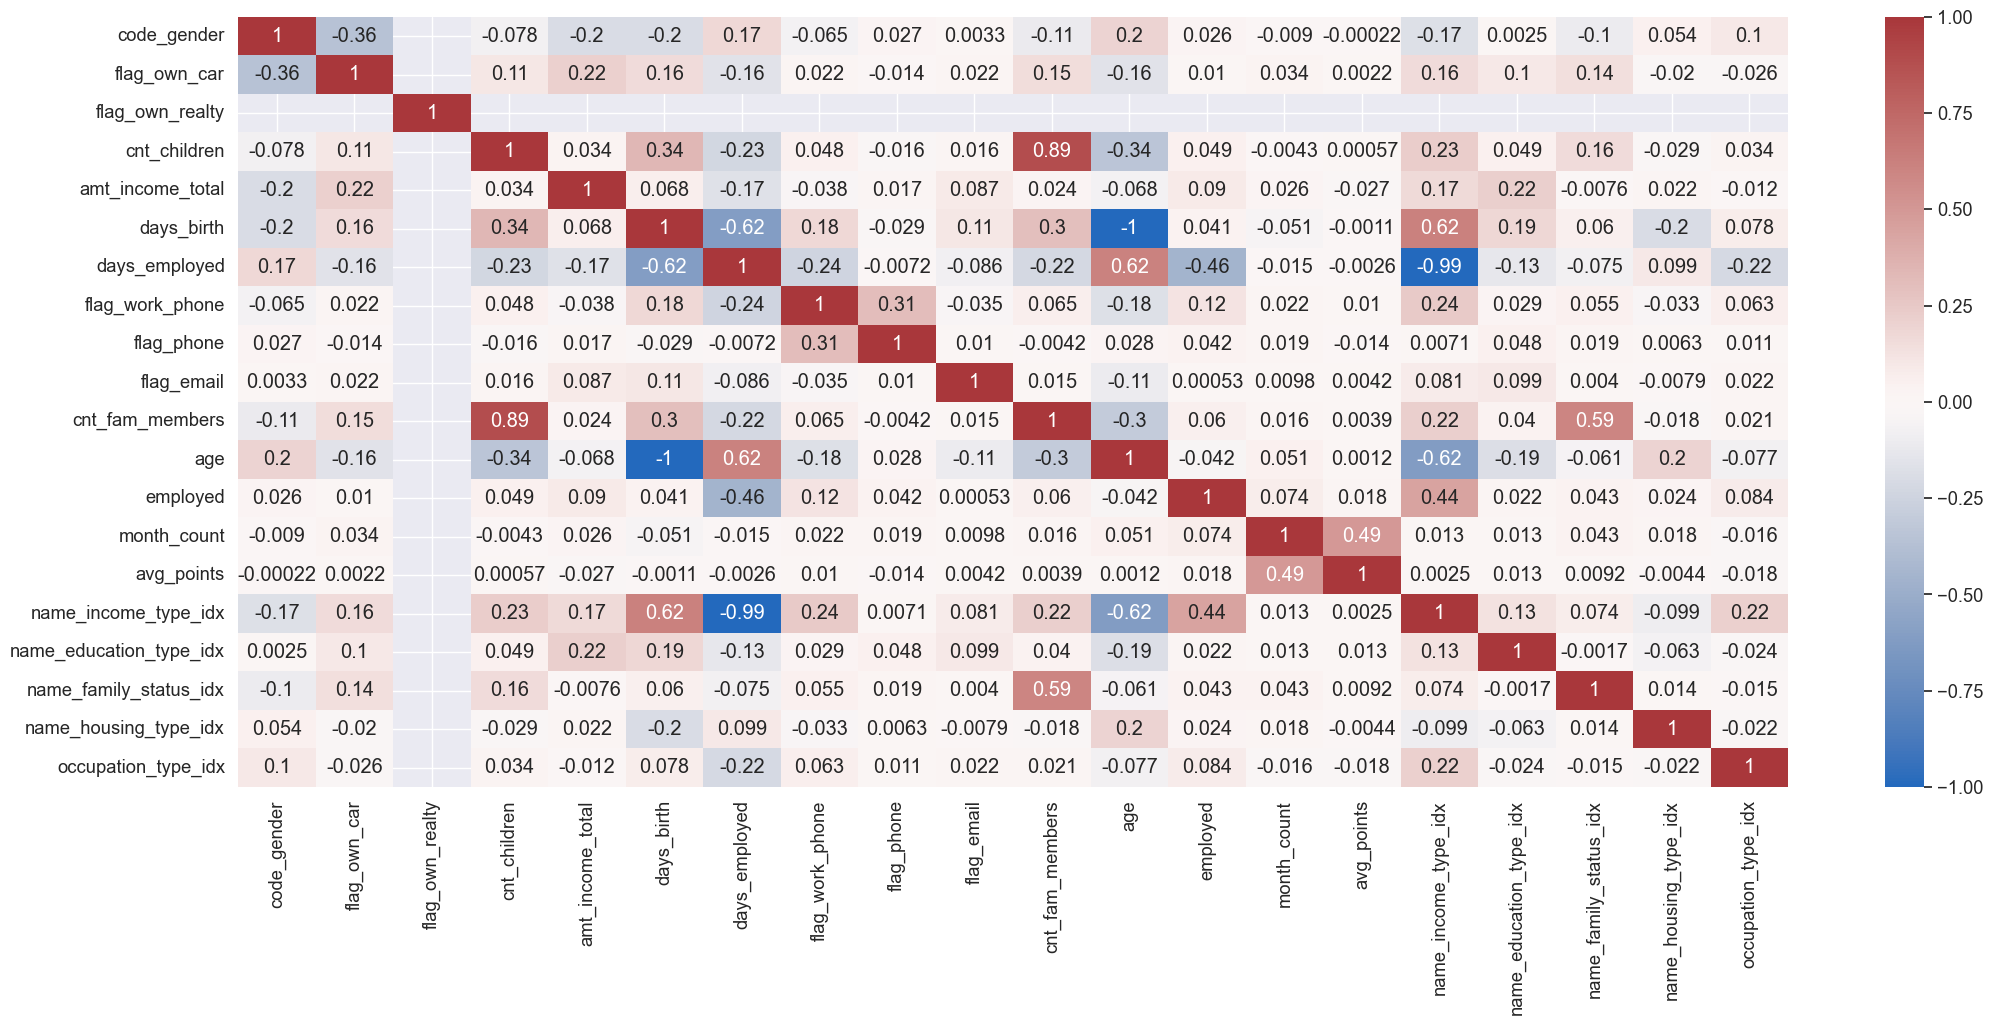

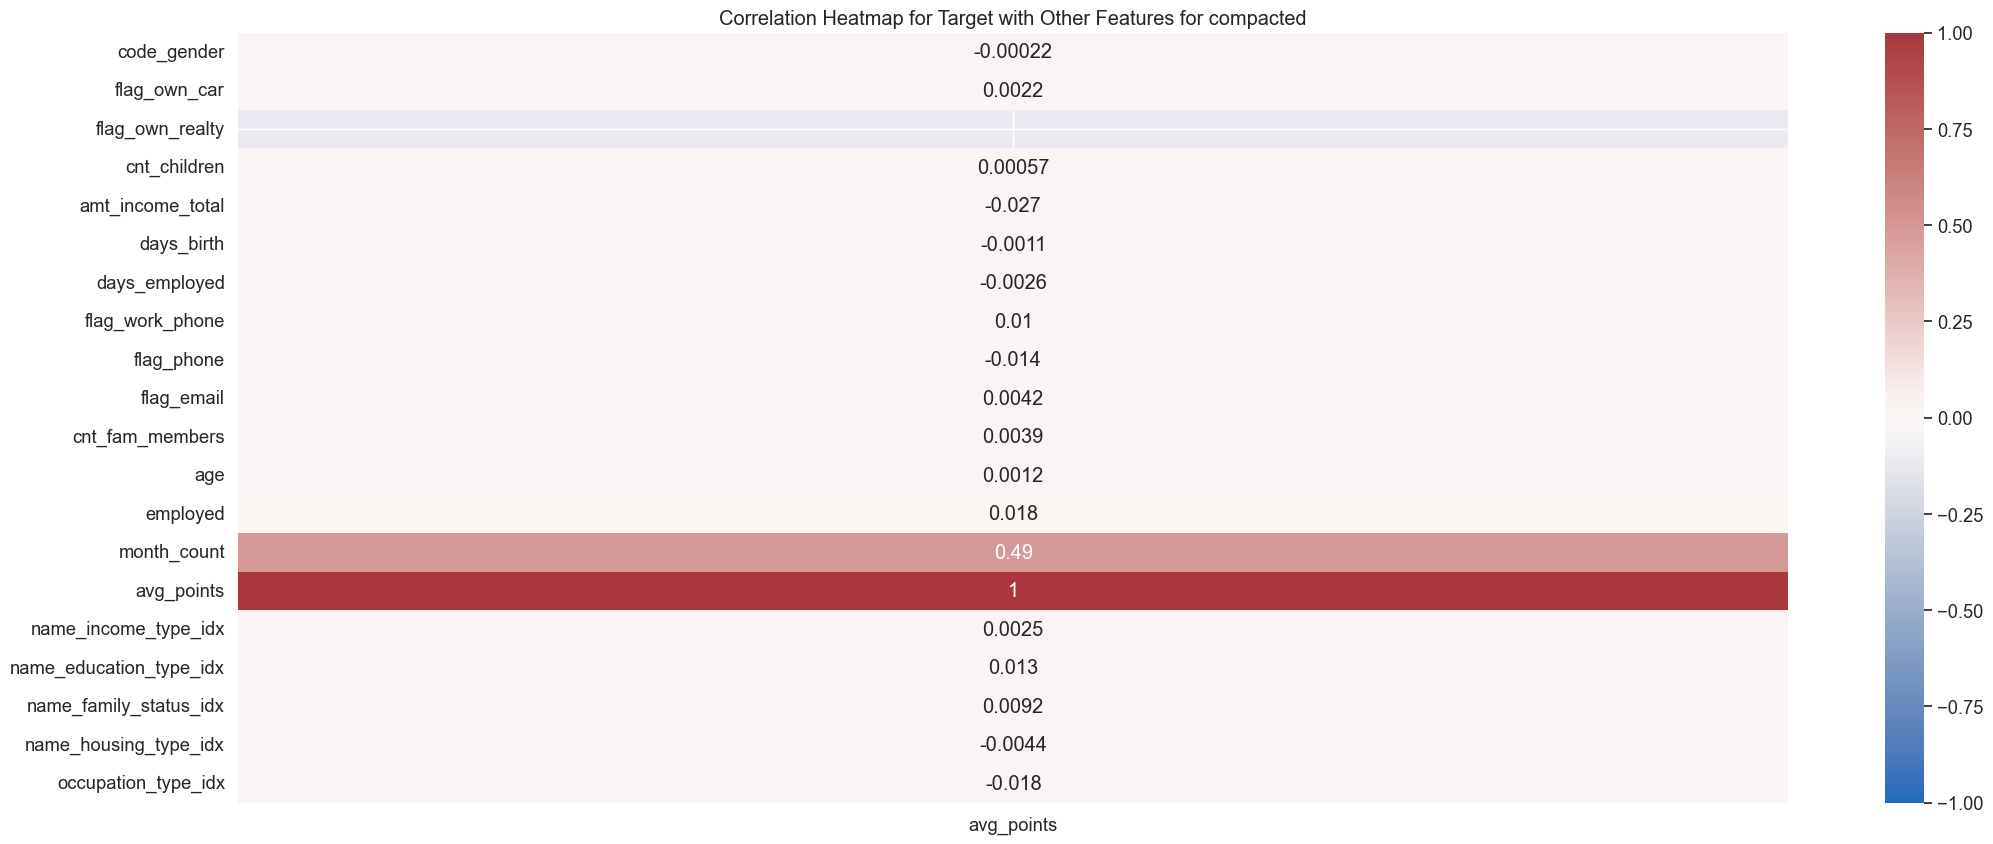

In [30]:
# find the correlation matrix without the tuning of the data for compacted data
elimination = ['id','name_income_type','name_education_type','occupation_type','name_family_status','name_housing_type']
included_columns = [col for col in df_compacted.columns if col != "label" and col not in elimination]

assembler = VectorAssembler(inputCols=included_columns, outputCol="features")
df_vector = assembler.transform(df_compacted).select("features")

correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

correlation_matrix_np = correlation_matrix.toArray()


correlation_df = pd.DataFrame(correlation_matrix_np, index=included_columns, columns=included_columns)

plt.figure(figsize=(25, 10))
sns.set(font_scale=1.2)
heat = sns.heatmap(data=correlation_df, annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.show()

target_correlation = correlation_df["avg_points"]

plt.figure(figsize=(25, 10))
sns.set(font_scale=1.2)
heat = sns.heatmap(data=target_correlation.to_frame(), annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Target with Other Features for compacted')
plt.show()

**PREPROCESSING**

In [39]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor,LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [52]:
selected_feature = ['amt_income_total','employed','month_count','name_education_type_idx','name_family_status_idx','occupation_type_idx']

# Create the feature vector
assembler = VectorAssembler(inputCols=selected_feature, outputCol='features')
data = assembler.transform(df_compacted)

# Select the final dataset
final_data = data.select(col('features'), col('avg_points').alias('label'))
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=131)
    
# Train the decision tree regression model
dt = DecisionTreeRegressor(featuresCol='features', labelCol='label')
dt_model = dt.fit(train_data)

# Make predictions
dt_predictions = dt_model.transform(test_data)

# Train the Linear regression model
lr = LinearRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train_data)

# Make predictions
lr_predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(dt_predictions)
r2 = evaluator.evaluate(dt_predictions, {evaluator.metricName: "r2"})
print(f"Decision Tree -- Root Mean Squared Error (RMSE): {rmse}")
print(f"Decision Tree -- R2: {r2}")

# Evaluate the model
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(lr_predictions)
r2 = evaluator.evaluate(lr_predictions, {evaluator.metricName: "r2"})
print(f"Linear Regression -- Root Mean Squared Error (RMSE) : {rmse}")
print(f"Linear Regression -- R2 : {r2}")

24/06/15 12:26:31 WARN Instrumentation: [ae9c6d85] regParam is zero, which might cause numerical instability and overfitting.


Decision Tree -- Root Mean Squared Error (RMSE): 11.245660778347792
Decision Tree -- R2: 0.28462605443793454


Linear Regression -- Root Mean Squared Error (RMSE) : 11.361832790777411
Linear Regression -- R2 : 0.26976953452654495


In [33]:
df_compacted.select('avg_points').summary().show()

+-------+------------------+
|summary|        avg_points|
+-------+------------------+
|  count|             36457|
|   mean|  24.0012544266611|
| stddev|13.155058350888195|
|    min| -46.8421052631579|
|    25%|11.666666666666666|
|    50%|              20.0|
|    75%|36.666666666666664|
|    max|              50.0|
+-------+------------------+



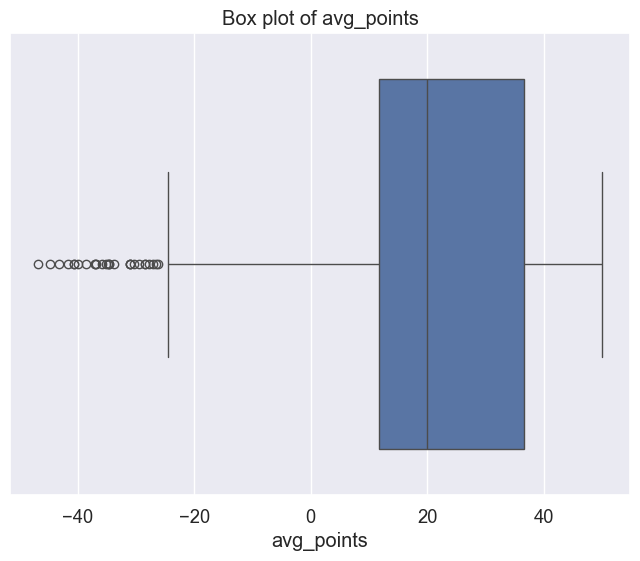

In [34]:
# Box plot for avg_points
df_pandas = df_compacted.select("avg_points").toPandas()
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_pandas['avg_points'])
plt.title('Box plot of avg_points')
plt.show()

In [35]:
from pyspark.sql.functions import expr

# Calculate quartiles and IQR
quantiles = df_compacted.stat.approxQuantile("avg_points", [0.25, 0.75], 0.05)
q1 = quantiles[0]
q3 = quantiles[1]
iqr = q3 - q1

# Define bounds for outlier detection
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identify outliers
outliers = df_compacted.filter((df_compacted["avg_points"] < lower_bound) | (df_compacted["avg_points"] > upper_bound))
# Filter out outliers
df_filtered = df_compacted.filter((df_compacted["avg_points"] >= lower_bound) & (df_compacted["avg_points"] <= upper_bound))

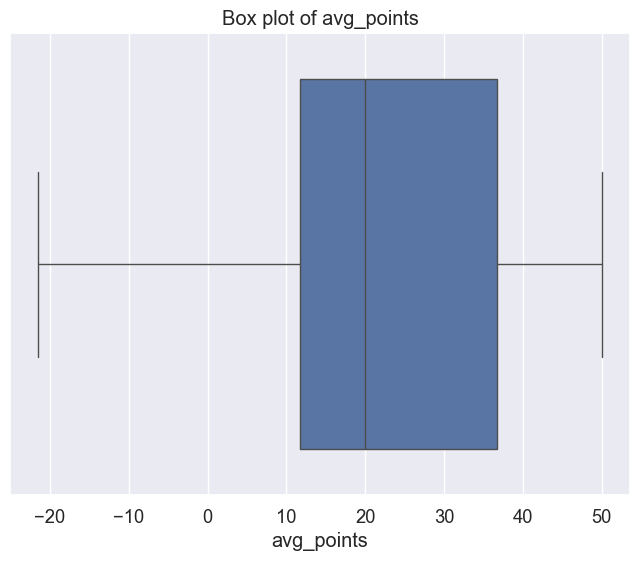

In [36]:
# Box plot for avg_points
df_pandas = df_filtered.select("avg_points").toPandas()
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_pandas['avg_points'])
plt.title('Box plot of avg_points')
plt.show()

In [62]:
selected_feature = ['amt_income_total','employed','month_count','name_education_type_idx','name_family_status_idx','occupation_type_idx']

# Create the feature vector
assembler = VectorAssembler(inputCols=selected_feature, outputCol='features')
data = assembler.transform(df_filtered)

# Select the final dataset
final_data = data.select(col('features'), col('avg_points').alias('label'))

# Split the data into training and testing sets
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed=122)

# Train the decision tree regression model
dt = DecisionTreeRegressor(featuresCol='features', labelCol='label')
dt_model = dt.fit(train_data)

# Make predictions
dt_predictions = dt_model.transform(test_data)

# Train the Linear regression model
lr = LinearRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train_data)

# Make predictions
lr_predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(dt_predictions)
r2 = evaluator.evaluate(dt_predictions, {evaluator.metricName: "r2"})
print(f"Decision Tree -- Root Mean Squared Error (RMSE): {rmse}")
print(f"Decision Tree -- R2: {r2}")

# Evaluate the model
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(lr_predictions)
r2 = evaluator.evaluate(lr_predictions, {evaluator.metricName: "r2"})
print(f"Linear Regression -- Root Mean Squared Error (RMSE) : {rmse}")
print(f"Linear Regression -- R2 : {r2}")

24/06/15 14:15:16 WARN Instrumentation: [ee77b1c5] regParam is zero, which might cause numerical instability and overfitting.


Decision Tree -- Root Mean Squared Error (RMSE): 11.150579591394933
Decision Tree -- R2: 0.27617982857162793


Linear Regression -- Root Mean Squared Error (RMSE) : 11.240404533927116
Linear Regression -- R2 : 0.26447120273090274
